In [1]:
from astropy.io import fits
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import redh3p as rhp
from PIL import Image

from lmfit import Model

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import os
spec_dir = os.path.abspath('./../../spec/')+'/'
figs_dir = os.path.abspath('./../../figures')

fjc35_rs = fits.open('h3p_spec35.fits', ignore_missing_end=True)[0].data
fjc36_rs = fits.open('h3p_spec36.fits', ignore_missing_end=True)[0].data
fjc37_rs = fits.open('h3p_spec37.fits', ignore_missing_end=True)[0].data

waverange36 = fits.open(spec_dir + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data
waverange35 = fits.open(spec_dir + 'order35/' + 'waverange.fits', ignore_missing_end=True)[0].data
waverange37 = fits.open(spec_dir + 'order37/' + 'waverange.fits', ignore_missing_end=True)[0].data

h3p_int = fits.open('h3p_int_shifted.fits', ignore_missing_end=True)[0].data
ref_sun = fits.open('ref_sun_38.fits', ignore_missing_end=True)[0].data

In [2]:
spec36_set = []

# fn = 16

top = 0
bot = 270

for fn in range(len(fjc36_rs)):
    
    # order 36
    spec36_h3p = np.concatenate((fjc36_rs[fn][:,:89],
                                 fjc36_rs[fn][:,189:201], 
                                 fjc36_rs[fn][:,101:1001]), axis=1)
    wave36_h3p = np.concatenate((waverange36[:89], waverange36[189:201], waverange36[101:1001]))
    
    spec36 = spec36_h3p
    
    order36_s1_off = 4.8838425430389965
    order36_s2_off = 4.116042668652459
    order36_s3_off = 3.355469840507057
    order36_s4_off = 21.519491602566646
    order36_s5_off = 2.3968771801033846
    order36_s6_off = 1.843007030131016

    order36_s1a = 90
    order36_s1b = 120
#     wave36_s1a = 85
#     wave36_s1b = 115

    order36_s2a = 282
    order36_s2b = 304
#     wave36_s2a = 278
#     wave36_s2b = 300

    order36_s3a = 405
    order36_s3b = 435
#     wave36_s3a = 402
#     wave36_s3b = 432

    order36_s4a = 506
    order36_s4b = 531
#     wave36_s4a = 490
#     wave36_s4b = 515

    order36_s5a = 638
    order36_s5b = 660
#     wave36_s5a = 632
#     wave36_s5b = 654

    order36_s6a = 842
    order36_s6b = 865
#     wave36_s6a = 841
#     wave36_s6b = 864

    order36_s1 = spec36[:,order36_s1a:order36_s1b]
    order36_s2 = spec36[:,order36_s2a:order36_s2b]
    order36_s3 = spec36[:,order36_s3a:order36_s3b]
    order36_s4 = spec36[:,order36_s4a:order36_s4b]
    order36_s5 = spec36[:,order36_s5a:order36_s5b]
    order36_s6 = spec36[:,order36_s6a:order36_s6b]

    wave36_s1 = waverange36[order36_s1a:order36_s1b] - (order36_s1_off * 2.9080e-05)
    wave36_s2 = waverange36[order36_s2a:order36_s2b] - (order36_s2_off * 2.9080e-05)
    wave36_s3 = waverange36[order36_s3a:order36_s3b] - (order36_s3_off * 2.9080e-05)
    wave36_s4 = waverange36[order36_s4a:order36_s4b] - (order36_s4_off * 2.9080e-05)
    wave36_s5 = waverange36[order36_s5a:order36_s5b] - (order36_s5_off * 2.9080e-05)
    wave36_s6 = waverange36[order36_s6a:order36_s6b] - (order36_s6_off * 2.9080e-05)

    wave36_to_fit = np.concatenate((wave36_s1,
                                    wave36_s2,
                                    wave36_s3,
                                    wave36_s4,
                                    wave36_s5,
                                    wave36_s6,))

#     wave36_model = np.concatenate((waverange36[order36_s1a:order36_s1b], 
#                                    waverange36[order36_s2a:order36_s2b], 
#                                    waverange36[order36_s3a:order36_s3b], 
#                                    waverange36[order36_s4a:order36_s4b], 
#                                    waverange36[order36_s5a:order36_s5b], 
#                                    waverange36[order36_s6a:order36_s6b],))
    
    noise_s1 = np.mean(np.hstack((order36_s1[:,0:5],order36_s1[:,25:30])), axis=1)
    reduced_s1 = (order36_s1.transpose() - noise_s1).transpose()

    noise_s2 = np.mean(np.hstack((order36_s2[:,0:4],order36_s2[:,18:22])), axis=1)
    reduced_s2 = (order36_s2.transpose() - noise_s2).transpose()

    noise_s3 = np.mean(np.hstack((order36_s3[:,0:5],order36_s3[:,25:30])), axis=1)
    reduced_s3 = (order36_s3.transpose() - noise_s3).transpose()

    noise_s4 = np.mean(np.hstack((order36_s4[:,0:2],order36_s4[:,17:20])), axis=1)
    reduced_s4 = (order36_s4.transpose() - noise_s4).transpose()

    noise_s5 = np.mean(np.hstack((order36_s5[:,0:5],order36_s5[:,17:22])), axis=1)
    reduced_s5 = (order36_s5.transpose() - noise_s5).transpose()

    noise_s6 = np.mean(np.hstack((order36_s6[:,0:5],order36_s6[:,18:22])), axis=1)
    reduced_s6 = (order36_s6.transpose() - noise_s6).transpose()


    spec36_to_fit = np.concatenate((reduced_s1, 
                                    reduced_s2, 
                                    reduced_s3, 
                                    reduced_s4, 
                                    reduced_s5, 
                                    reduced_s6,), axis=1)
    
#     spec36_to_fit = np.concatenate((order36_s1,
#                                     order36_s2,
#                                     order36_s3,
#                                     order36_s4,
#                                     order36_s5,
#                                     order36_s6,), axis=1)

    spec36_set.append(spec36_to_fit)
    
spec36_dat = np.array(spec36_set)

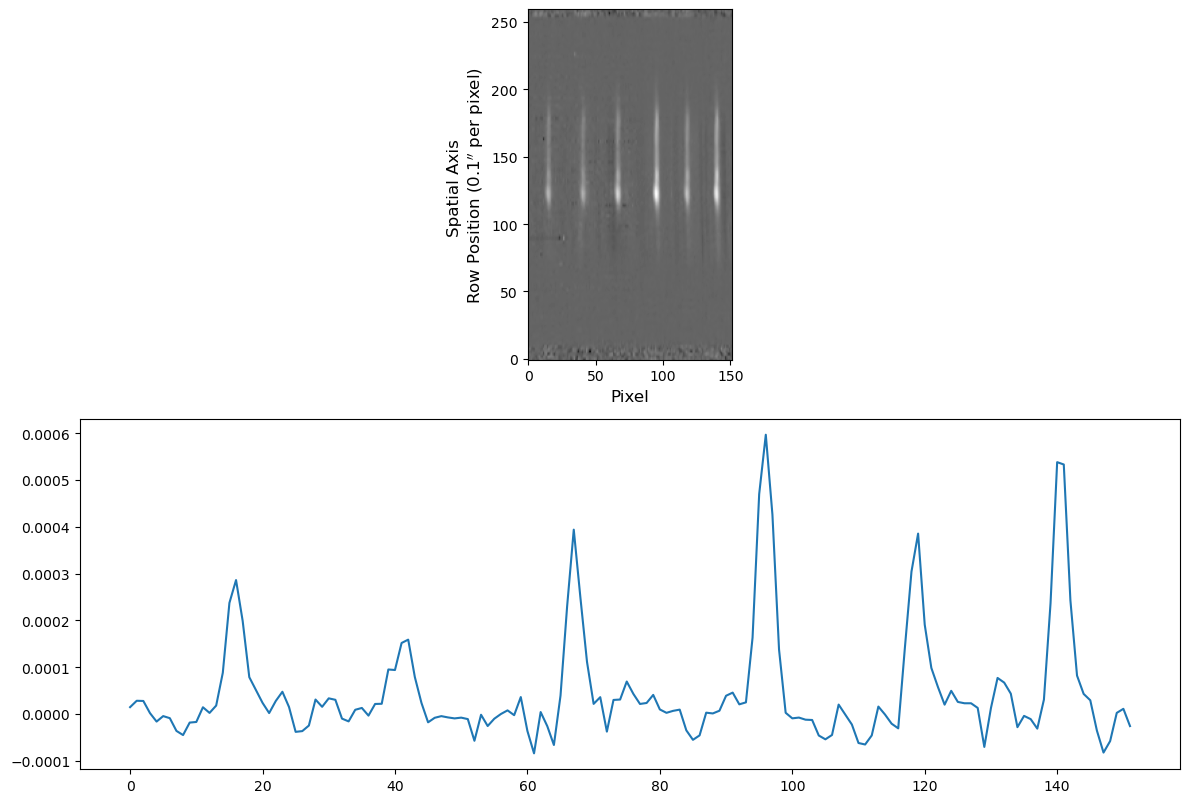

In [3]:
fig = plt.figure(figsize=(12,12), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spec36_dat[0],
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

fig.add_subplot(312)
plt.plot(spec36_dat[16][120])

In [23]:
import h3ppy
import logging
logging.disable(logging.CRITICAL)

# model2 = h2.model(dens = 3e25, temperature = 1000, R = 25000, wavelength = wave)

centers = [2.1223, 2.1278, 2.1315, 2.1349, 2.1381, 2.144] # 2.1349
cpos = np.arange(6) * 25 + 15

h3p_dens_map = []
h3p_dens_map_errs = []

h3p_temp_map = []
h3p_temp_map_errs = []

# h3p_offset = []
# h3p_sigma = []
# h3p_background = []
    
# h3p_tot_em = []

print('H3p LOOP START')
for fn in range(len(spec36_dat)):
# for fn in range(0,2):
    print()
    print('Frame Number = ' + str(fn))
    print()
    
    h3p = h3ppy.h3p(line_list_file='h3p_line_list_neale_1996_subset_211_215.txt')
    h2 = h3ppy.h2()
    
    model = h3p.model(density = 2e16, temperature = 1000, R = 25000, wavelength = wave36_to_fit)

    dens = np.zeros(301)
    dens_errs = np.zeros(301)

    temp = np.zeros(301)
    temp_errs = np.zeros(301)

    offset_0 = np.zeros(301)
    sigma_0 = np.zeros(301)
    background_0 = np.zeros(301)

    tot_em = np.zeros(301)
    
    for i in range(90,240):
        spec = spec36_dat[fn][i]

        h3p.set(wavelength = wave36_to_fit, data = spec, R = 25000, dens = 3e16, temperature = 1000)

        xx = range(len(spec))

        fit = h3p.fit(params_to_fit=['density','temperature'], verbose=False)
#         fit = h3p.fit(params_to_fit=['density','temperature', 'offset_0', 'sigma_0', 'background_0'], verbose=False)

        vars, errs = h3p.get_results(verbose=False)

        if bool(vars)== False:
            print('i = '+str(i)+', false fit')

#             fig, ax = plt.subplots()
#             ax.plot(xx, spec * 1e3, '-', label = 'Observation')
#             ax.plot(xx, fit * 1e3, label = 'h3ppy H$_3^+$ fit')
#             ax.plot(xx, model * 1e3, label = 'Model')
#             ax.set(xlabel = h3p.xlabel(), ylabel = h3p.ylabel(prefix = 'm'), xticks = cpos, title = 'i = '+str(i))
#             ax.set_xticklabels(centers)
#             ax.legend(frameon = False)

            continue
        if bool(vars) == True:
            print('i = '+str(i)+', dens = '+str(vars['density'])+', temp = '+str(vars['temperature']))

#             fig, ax = plt.subplots()
#             ax.plot(xx, spec * 1e3, '-', label = 'Observation')
#             ax.plot(xx, fit * 1e3, label = 'h3ppy H$_3^+$ fit')
#             ax.plot(xx, model * 1e3, label = 'Model')
#             ax.set(xlabel = h3p.xlabel(), ylabel = h3p.ylabel(prefix = 'm'), xticks = cpos, title = 'i = '+str(i))
#             ax.set_xticklabels(centers)
#             ax.legend(frameon = False)

            dens[i] = vars['density']
            dens_errs[i] = errs['density']

            temp[i] = vars['temperature']
            temp_errs[i] = errs['temperature']

#             tot_em[i] = h3p.total_emission()
            
    h3p_dens_map.append(dens)
    h3p_dens_map_errs.append(dens_errs)
    
    h3p_temp_map.append(temp)
    h3p_temp_map_errs.append(temp_errs)
        
print('DONE')

h3p_density = np.array(h3p_dens_map)
h3p_temperature = np.array(h3p_temp_map)
h3p_density_errs = np.array(h3p_dens_map_errs)
h3p_temperature_errs = np.array(h3p_temp_map_errs)

H3p LOOP START

Frame Number = 0

i = 90, false fit
i = 91, dens = 1.904058165893041e+25, temp = 1000.0000000000024
i = 92, dens = 4488962378825728.0, temp = 999.9999999710213
i = 93, dens = 5.637843643214601e+16, temp = 625.209530046767
i = 94, dens = 3.73135780520269e+16, temp = 647.7320946843433
i = 95, dens = 6.9378383384091576e+16, temp = 608.808144610577
i = 96, dens = 3.8357003825512966e+17, temp = 529.3859508807221
i = 97, false fit
i = 98, dens = 3.5518999671794904e+16, temp = 662.9200678349946
i = 99, dens = 1.1957955613614536e+16, temp = 751.1680820016315
i = 100, dens = 8654455315327168.0, temp = 789.952816132524
i = 101, dens = 1.0158564082943798e+16, temp = 783.9262436876782
i = 102, dens = 1.4333996570181788e+16, temp = 759.9502899570944
i = 103, dens = 1.4216110181091008e+16, temp = 767.8786214444654
i = 104, dens = 9848365289747032.0, temp = 811.6584338603082
i = 105, dens = 7479126904371244.0, temp = 852.4907393944073
i = 106, dens = 7510815907148418.0, temp = 865.688

i = 91, dens = 2.259435053509558e+16, temp = 676.9330333854573
i = 92, dens = 1.2676247820185222e+16, temp = 732.6445968173057
i = 93, dens = 1.246475862256409e+16, temp = 746.4975913947359
i = 94, dens = 1.5869499518897814e+16, temp = 733.1276549504323
i = 95, dens = 2.2225699429950268e+16, temp = 713.1318420175544
i = 96, dens = 2.727836076333815e+16, temp = 708.1960749559738
i = 97, dens = 2.4279272887174908e+16, temp = 726.5383907094717
i = 98, dens = 1.56484904071082e+16, temp = 768.8993529109571
i = 99, dens = 1.014207455602873e+16, temp = 816.6953283183705
i = 100, dens = 8410286213576133.0, temp = 847.6972423348659
i = 101, dens = 8302591116136677.0, temp = 861.8802184028308
i = 102, dens = 8834865338732587.0, temp = 867.2969702778864
i = 103, dens = 9528796095258340.0, temp = 872.3786073653037
i = 104, dens = 1.0338117211242546e+16, temp = 878.8376203741295
i = 105, dens = 1.1564640604005652e+16, temp = 883.664615621332
i = 106, dens = 1.3747869210659648e+16, temp = 883.933272

i = 232, false fit
i = 233, dens = 116204762361856.0, temp = 999.9995214412186
i = 234, false fit
i = 235, false fit
i = 236, false fit
i = 237, false fit
i = 238, false fit
i = 239, false fit

Frame Number = 2

i = 90, dens = 1.041716917509827e+16, temp = 792.413651558194
i = 91, dens = 2.0846091928942516e+16, temp = 742.3065782183548
i = 92, dens = 1.7200469665589918e+16, temp = 769.3103316930741
i = 93, dens = 1.080861140751933e+16, temp = 823.7936582801995
i = 94, dens = 9139781524256162.0, temp = 851.1047321100314
i = 95, dens = 9856637978557288.0, temp = 852.9001611346611
i = 96, dens = 1.1817773168115096e+16, temp = 845.1461352691691
i = 97, dens = 1.4143978079308442e+16, temp = 839.2837975430322
i = 98, dens = 1.5909477159234844e+16, temp = 841.2945317066261
i = 99, dens = 1.6793223653466238e+16, temp = 852.0874744089583
i = 100, dens = 1.7219890183037812e+16, temp = 868.6703663274393
i = 101, dens = 1.820667911864599e+16, temp = 884.4249023036517
i = 102, dens = 1.988126126831

i = 223, false fit
i = 224, false fit
i = 225, dens = 336316010133504.0, temp = 999.9736642271492
i = 226, false fit
i = 227, false fit
i = 228, dens = 180578961510912.0, temp = 999.9001770640507
i = 229, false fit
i = 230, false fit
i = 231, false fit
i = 232, false fit
i = 233, dens = 1232535701724595.8, temp = 696.8324653013927
i = 234, dens = 128546609349787.98, temp = 897.1086472929104
i = 235, dens = 56072964873876.17, temp = 957.6309689840882
i = 236, false fit
i = 237, false fit
i = 238, false fit
i = 239, false fit

Frame Number = 3

i = 90, dens = 1.7832066106614268e+16, temp = 796.3481869724687
i = 91, dens = 1.7745400561168236e+16, temp = 812.0737538487609
i = 92, dens = 1.4259460135148664e+16, temp = 850.7792525824551
i = 93, dens = 1.2757619059078658e+16, temp = 882.7884706742009
i = 94, dens = 1.5353452301202512e+16, temp = 884.6279034109654
i = 95, dens = 2.0144826976823148e+16, temp = 876.2799059868676
i = 96, dens = 2.4434113905386216e+16, temp = 874.7427899398774
i =

i = 214, dens = 197950463239680.5, temp = 874.0030888873102
i = 215, false fit
i = 216, false fit
i = 217, false fit
i = 218, dens = 117901879537664.0, temp = 999.9950362152373
i = 219, false fit
i = 220, false fit
i = 221, false fit
i = 222, false fit
i = 223, false fit
i = 224, false fit
i = 225, false fit
i = 226, false fit
i = 227, false fit
i = 228, false fit
i = 229, false fit
i = 230, false fit
i = 231, false fit
i = 232, false fit
i = 233, false fit
i = 234, false fit
i = 235, false fit
i = 236, false fit
i = 237, false fit
i = 238, false fit
i = 239, false fit

Frame Number = 4

i = 90, dens = 2.356665069818516e+16, temp = 881.7017801173527
i = 91, dens = 2.4617554634026348e+16, temp = 890.6818406551369
i = 92, dens = 2.5123862017793764e+16, temp = 897.5067297483222
i = 93, dens = 2.5259110075158004e+16, temp = 902.0469911657525
i = 94, dens = 2.4942331235059356e+16, temp = 905.7197066812081
i = 95, dens = 2.402960493197654e+16, temp = 908.6326303098419
i = 96, dens = 2.249525

i = 226, false fit
i = 227, false fit
i = 228, false fit
i = 229, false fit
i = 230, false fit
i = 231, false fit
i = 232, dens = 79300738263281.84, temp = 845.3689244436522
i = 233, false fit
i = 234, false fit
i = 235, false fit
i = 236, false fit
i = 237, false fit
i = 238, false fit
i = 239, false fit

Frame Number = 5

i = 90, dens = 2.0572723615470124e+16, temp = 873.7088346342653
i = 91, dens = 2.0147825755249748e+16, temp = 869.7801612056177
i = 92, dens = 1.828143517395458e+16, temp = 876.4741077501753
i = 93, dens = 1.6335844700268562e+16, temp = 886.8902694746611
i = 94, dens = 1.576421940710341e+16, temp = 889.3333257118795
i = 95, dens = 1.608490366846529e+16, temp = 885.1947141957182
i = 96, dens = 1.6528176541265934e+16, temp = 879.701030883928
i = 97, dens = 1.7179106154461776e+16, temp = 873.4026076066975
i = 98, dens = 1.81010656376226e+16, temp = 867.1853203872876
i = 99, dens = 1.8623578615441176e+16, temp = 865.2658011094683
i = 100, dens = 1.8507868667676292e+16, 

i = 94, dens = 1.4554229706624458e+16, temp = 867.8130335562629
i = 95, dens = 1.5645302479385024e+16, temp = 862.1801507939111
i = 96, dens = 1.6402536619265504e+16, temp = 858.9551726105434
i = 97, dens = 1.7252468755859868e+16, temp = 854.9283684042359
i = 98, dens = 1.8524896562737148e+16, temp = 848.2777151886376
i = 99, dens = 1.852745096218543e+16, temp = 848.9686618079705
i = 100, dens = 1.6583377532989858e+16, temp = 861.579109484287
i = 101, dens = 1.4838069220351286e+16, temp = 874.5879140131701
i = 102, dens = 1.4093990005204642e+16, temp = 880.7084326836689
i = 103, dens = 1.3422896497841432e+16, temp = 885.4025901986623
i = 104, dens = 1.251501731827718e+16, temp = 890.9979364400155
i = 105, dens = 1.1837598713926664e+16, temp = 893.4187714838421
i = 106, dens = 1.1733740793963462e+16, temp = 889.0172796988694
i = 107, dens = 1.2461386492621314e+16, temp = 875.8018678496246
i = 108, dens = 1.330514755020796e+16, temp = 861.6385210645133
i = 109, dens = 1.2406924846757574e

i = 112, dens = 7249008681098083.0, temp = 856.9859215788979
i = 113, dens = 5945320682363090.0, temp = 871.5912342450357
i = 114, dens = 4474386689142057.0, temp = 898.6799587568802
i = 115, dens = 3741109847862200.0, temp = 919.1746479489811
i = 116, dens = 4036804311387894.0, temp = 910.0307297433477
i = 117, dens = 5589300272233771.0, temp = 870.4804584854489
i = 118, dens = 6842649510883638.0, temp = 844.8257019557896
i = 119, dens = 5921761716718472.0, temp = 854.3771279333399
i = 120, dens = 5214085475022781.0, temp = 863.5097824916742
i = 121, dens = 6064653475119483.0, temp = 845.8583807727518
i = 122, dens = 7583774361411642.0, temp = 823.169064184519
i = 123, dens = 8434018439583656.0, temp = 811.9457385554613
i = 124, dens = 7720116676523549.0, temp = 815.8145572130741
i = 125, dens = 6266952561919858.0, temp = 830.9068322979501
i = 126, dens = 6056005607871524.0, temp = 837.8210057597602
i = 127, dens = 6580242228806098.0, temp = 838.6331927946984
i = 128, dens = 594281456

i = 133, dens = 7202157074621815.0, temp = 968.3401984359931
i = 134, dens = 7363803866558767.0, temp = 984.498510115171
i = 135, dens = 7246683046275237.0, temp = 1006.1467015400958
i = 136, dens = 7612259501721501.0, temp = 1014.3382735037386
i = 137, dens = 8087564141788161.0, temp = 1018.7221723846366
i = 138, dens = 8469359093768821.0, temp = 1024.7766859441324
i = 139, dens = 9105892616639636.0, temp = 1025.6733995612933
i = 140, dens = 1.0040595640687282e+16, temp = 1020.7417845949233
i = 141, dens = 1.0701620151322958e+16, temp = 1018.1228365689475
i = 142, dens = 1.0864680108208806e+16, temp = 1019.8676147647722
i = 143, dens = 1.0867731840880058e+16, temp = 1021.6176897901532
i = 144, dens = 1.0838891059711994e+16, temp = 1020.989605988189
i = 145, dens = 1.0679170990611842e+16, temp = 1017.5481785150408
i = 146, dens = 1.0459616281550208e+16, temp = 1010.4853066728443
i = 147, dens = 1.0363513483409544e+16, temp = 999.0517882687749
i = 148, dens = 1.0119792294645504e+16, tem

i = 157, dens = 2635693285836736.5, temp = 809.9158340522686
i = 158, dens = 3179025937044117.5, temp = 779.0926198879617
i = 159, dens = 3528051922929738.0, temp = 773.8300287355519
i = 160, dens = 3942218199055752.5, temp = 744.8337518403966
i = 161, false fit
i = 162, false fit
i = 163, false fit
i = 164, false fit
i = 165, dens = 1058402550282240.0, temp = 999.9935992234708
i = 166, false fit
i = 167, dens = 814991651373056.0, temp = 999.999993039548
i = 168, false fit
i = 169, dens = 623028115531712.0, temp = 999.8660023369351
i = 170, false fit
i = 171, dens = 680797636456448.0, temp = 999.9528253624546
i = 172, false fit
i = 173, false fit
i = 174, dens = 135252396998656.0, temp = 999.9999849132765
i = 175, false fit
i = 176, false fit
i = 177, dens = 9198237098656788.0, temp = 660.3423982422219
i = 178, dens = 4155625707808113.0, temp = 696.1606735446804
i = 179, dens = 515429911991772.06, temp = 841.2313286437671
i = 180, dens = 58758841231304.14, temp = 1132.5544272831066
i =

i = 205, false fit
i = 206, false fit
i = 207, false fit
i = 208, false fit
i = 209, false fit
i = 210, false fit
i = 211, false fit
i = 212, false fit
i = 213, dens = 100991713111552.0, temp = 999.9976451130548
i = 214, false fit
i = 215, false fit
i = 216, false fit
i = 217, false fit
i = 218, dens = 310874027851776.0, temp = 999.9999999968742
i = 219, false fit
i = 220, false fit
i = 221, false fit
i = 222, false fit
i = 223, false fit
i = 224, false fit
i = 225, false fit
i = 226, false fit
i = 227, dens = 97262074098024.0, temp = 999.6898551444469
i = 228, false fit
i = 229, false fit
i = 230, false fit
i = 231, false fit
i = 232, false fit
i = 233, false fit
i = 234, false fit
i = 235, false fit
i = 236, false fit
i = 237, false fit
i = 238, false fit
i = 239, false fit

Frame Number = 11

i = 90, dens = 4007249376851607.5, temp = 884.6354433524383
i = 91, dens = 4721311698406749.0, temp = 871.2807933378667
i = 92, dens = 3365547747481900.5, temp = 911.8875457523646
i = 93, dens 

i = 111, dens = 1577779668155135.5, temp = 913.0084577956623
i = 112, dens = 983132641742005.2, temp = 968.5466005991203
i = 113, dens = 713328571650815.6, temp = 1009.2741762613064
i = 114, dens = 766894901615022.5, temp = 995.9804322972745
i = 115, dens = 1267024235404646.5, temp = 929.8180273463167
i = 116, dens = 2004002339984930.8, temp = 873.2210342657104
i = 117, dens = 2303329023082294.5, temp = 845.4168275271624
i = 118, dens = 2177066273527205.8, temp = 836.3468986310489
i = 119, dens = 1976578723030212.5, temp = 838.8524469319527
i = 120, dens = 2040792311389640.2, temp = 834.7805933049921
i = 121, dens = 2413628906614118.5, temp = 820.5211524286068
i = 122, dens = 2516733893004935.5, temp = 819.9511272741785
i = 123, dens = 2466671878083500.5, temp = 822.3396078856931
i = 124, dens = 3613069708677537.5, temp = 777.6487766126278
i = 125, dens = 1.2591185649833262e+16, temp = 668.237452272082
i = 126, dens = 2.2240594435243144e+16, temp = 623.9415776324655
i = 127, dens = 258

i = 168, false fit
i = 169, false fit
i = 170, false fit
i = 171, false fit
i = 172, false fit
i = 173, false fit
i = 174, false fit
i = 175, false fit
i = 176, false fit
i = 177, false fit
i = 178, false fit
i = 179, false fit
i = 180, false fit
i = 181, false fit
i = 182, false fit
i = 183, false fit
i = 184, false fit
i = 185, false fit
i = 186, false fit
i = 187, false fit
i = 188, false fit
i = 189, false fit
i = 190, false fit
i = 191, dens = 59279756619088.21, temp = 909.591929658698
i = 192, false fit
i = 193, false fit
i = 194, dens = 787187275661312.0, temp = 999.9999783966318
i = 195, false fit
i = 196, dens = 1.253802136259946e+19, temp = 1000.0000000000043
i = 197, dens = 147453653846016.0, temp = 999.9985853334077
i = 198, dens = 936182953773317.2, temp = 677.5211883401403
i = 199, false fit
i = 200, false fit
i = 201, false fit
i = 202, false fit
i = 203, false fit
i = 204, false fit
i = 205, false fit
i = 206, false fit
i = 207, false fit
i = 208, false fit
i = 209, fal

i = 107, dens = 447540249112403.44, temp = 888.4936663852087
i = 108, dens = 2.4830298577235418e+17, temp = 471.7362695934703
i = 109, dens = 885800936469536.0, temp = 999.5642483060989
i = 110, false fit
i = 111, dens = 575112831041536.0, temp = 999.999999764811
i = 112, dens = 178936149255959.22, temp = 1031.918941385543
i = 113, dens = 714834741207877.1, temp = 847.9926689634206
i = 114, dens = 1.0171924050418448e+16, temp = 635.3934177411492
i = 115, false fit
i = 116, dens = 758712591280832.0, temp = 999.7751780344228
i = 117, false fit
i = 118, dens = 613790543085568.0, temp = 999.9994396459394
i = 119, false fit
i = 120, dens = 735403763000224.0, temp = 999.5425139616572
i = 121, false fit
i = 122, dens = 786150813859840.0, temp = 999.9999999999876
i = 123, false fit
i = 124, dens = 548541722268160.0, temp = 999.970169017626
i = 125, dens = 136323966742331.92, temp = 1038.097816784407
i = 126, dens = 265060272691572.06, temp = 957.165670955992
i = 127, dens = 5465695194023184.0,

i = 161, dens = 2.5642834240596144e+16, temp = 877.1346602201696
i = 162, dens = 2.5664540989692916e+16, temp = 876.355485824659
i = 163, dens = 2.4827601252524676e+16, temp = 880.6126717107775
i = 164, dens = 2.278425985581288e+16, temp = 891.12023823621
i = 165, dens = 2.069548416476326e+16, temp = 902.8020463057262
i = 166, dens = 2.021774861247147e+16, temp = 905.6844720026769
i = 167, dens = 2.110950146400884e+16, temp = 900.2041684570399
i = 168, dens = 2.225321398508758e+16, temp = 893.1341722344092
i = 169, dens = 2.284305449652263e+16, temp = 889.1657297536221
i = 170, dens = 2.239637465363827e+16, temp = 891.1555889855794
i = 171, dens = 2.1672036508224468e+16, temp = 895.9023166898273
i = 172, dens = 2.1413862848063772e+16, temp = 899.7531915582664
i = 173, dens = 2.0826707256109096e+16, temp = 906.6243262227947
i = 174, dens = 1.9589884989910428e+16, temp = 918.0500135379236
i = 175, dens = 1.9247264961419704e+16, temp = 923.4010758694895
i = 176, dens = 2.057309821581585e+

i = 146, dens = 3.640605867318468e+16, temp = 846.0886527520958
i = 147, dens = 3.3242814669746376e+16, temp = 848.1219171762922
i = 148, dens = 2.9164047546477984e+16, temp = 854.9502604832506
i = 149, dens = 2.7848310883130624e+16, temp = 854.5221241973137
i = 150, dens = 2.7722233750736564e+16, temp = 851.7082308996147
i = 151, dens = 2.578397464433269e+16, temp = 857.7490663091993
i = 152, dens = 2.4001580005830736e+16, temp = 864.1927333454724
i = 153, dens = 2.4548700861802984e+16, temp = 859.4569721114465
i = 154, dens = 2.565076058795905e+16, temp = 851.032650833581
i = 155, dens = 2.5010891213574188e+16, temp = 848.1853696406922
i = 156, dens = 2.2610159615954068e+16, temp = 851.2775218045524
i = 157, dens = 1.93647703147138e+16, temp = 858.5147880410345
i = 158, dens = 1.6806656260683968e+16, temp = 865.0658487705819
i = 159, dens = 1.553535963097279e+16, temp = 867.6045838565364
i = 160, dens = 1.4743740079350526e+16, temp = 870.4163264944021
i = 161, dens = 1.36218754292891

i = 129, dens = 2.9740997790200812e+16, temp = 940.6245527399282
i = 130, dens = 3.120138123198254e+16, temp = 931.8968150377736
i = 131, dens = 3.2794608351257948e+16, temp = 922.116987933665
i = 132, dens = 3.416115823310978e+16, temp = 912.4380058423568
i = 133, dens = 3.501422897663277e+16, temp = 904.0132643738235
i = 134, dens = 3.5319580752958704e+16, temp = 897.2004411404143
i = 135, dens = 3.618041000910872e+16, temp = 888.5440807175676
i = 136, dens = 3.840994562505037e+16, temp = 876.079413632665
i = 137, dens = 4.008907998113484e+16, temp = 865.962502748195
i = 138, dens = 3.9657968416611816e+16, temp = 861.9157494318112
i = 139, dens = 3.914012797859961e+16, temp = 857.9045260508785
i = 140, dens = 3.946682728698813e+16, temp = 851.023317041968
i = 141, dens = 3.8193863605072e+16, temp = 847.4373920339259
i = 142, dens = 3.4533901602868068e+16, temp = 850.0853207675036
i = 143, dens = 3.0715349267408244e+16, temp = 854.8825314740099
i = 144, dens = 2.829987747674163e+16, t

i = 111, dens = 1.0023088794601286e+16, temp = 821.1649302389521
i = 112, dens = 1.1367136610875392e+16, temp = 824.6906360416915
i = 113, dens = 1.4302998330969864e+16, temp = 818.6500917903306
i = 114, dens = 1.635103175150229e+16, temp = 822.374224703499
i = 115, dens = 1.594413882130988e+16, temp = 842.5287217110624
i = 116, dens = 1.5913822293724668e+16, temp = 861.9840419862288
i = 117, dens = 1.7885456734755602e+16, temp = 869.8823409986254
i = 118, dens = 2.138064574383647e+16, temp = 871.38480889023
i = 119, dens = 2.537715461514287e+16, temp = 873.0606726847957
i = 120, dens = 2.7955174629269104e+16, temp = 880.929959213766
i = 121, dens = 2.8973671694313652e+16, temp = 893.9408926529472
i = 122, dens = 3.060142319224277e+16, temp = 904.5787549058243
i = 123, dens = 3.340804035188703e+16, temp = 910.0641090467019
i = 124, dens = 3.631254592124636e+16, temp = 912.1589405924431
i = 125, dens = 3.774781089006228e+16, temp = 915.2037159360958
i = 126, dens = 3.605625082071744e+16

i = 91, dens = 3719894436817032.0, temp = 748.5405179764759
i = 92, dens = 3447137931350393.0, temp = 763.8402104150632
i = 93, dens = 4272338348123915.5, temp = 754.8155531692217
i = 94, dens = 6950289229180124.0, temp = 723.9872872684007
i = 95, dens = 1.0924724620068708e+16, temp = 697.3448557218679
i = 96, dens = 1.278404737553892e+16, temp = 693.3196073717813
i = 97, dens = 1.46776743998031e+16, temp = 696.1899728780651
i = 98, dens = 1.8824333886280016e+16, temp = 695.6448074264866
i = 99, dens = 1.9945703181850732e+16, temp = 703.1504959071638
i = 100, dens = 1.6599869341683494e+16, temp = 720.9994517482826
i = 101, dens = 1.5112624839914522e+16, temp = 732.4792968753435
i = 102, dens = 1.7036399665369656e+16, temp = 730.646714617788
i = 103, dens = 1.747468867398979e+16, temp = 736.1457976159055
i = 104, dens = 1.4942589683820896e+16, temp = 755.0923727444348
i = 105, dens = 1.2067404114365966e+16, temp = 779.0715208943393
i = 106, dens = 1.108615895890732e+16, temp = 793.91187

i = 223, dens = 8666238365022921.0, temp = 851.6933681935853
i = 224, dens = 6524014606120042.0, temp = 866.5298480897328
i = 225, dens = 6066162522171907.0, temp = 859.8284474170962
i = 226, dens = 7101644461502052.0, temp = 830.5889737599844
i = 227, dens = 7996338187141487.0, temp = 811.2748890450399
i = 228, dens = 7702473176778960.0, temp = 812.3502475948733
i = 229, dens = 6276137158643504.0, temp = 833.5861292419436
i = 230, dens = 4832104450800392.0, temp = 860.8289257341538
i = 231, dens = 3800039179175870.5, temp = 881.5488813369261
i = 232, dens = 3322165922519469.5, temp = 885.49744002876
i = 233, dens = 3264799069520413.5, temp = 871.5709325288999
i = 234, dens = 2454162709957407.0, temp = 881.2420504870291
i = 235, dens = 1031005237458417.0, temp = 956.202724407018
i = 236, dens = 459469080210107.75, temp = 1037.814340811986
i = 237, dens = 483283269794189.4, temp = 991.592629963953
i = 238, dens = 951080638086204.1, temp = 845.479216375886
i = 239, false fit

Frame Numbe

i = 205, dens = 1.4844936092549614e+16, temp = 981.8011307674562
i = 206, dens = 1.4750998467399868e+16, temp = 974.4441754513458
i = 207, dens = 1.4479213276654038e+16, temp = 966.3992109084326
i = 208, dens = 1.3467637524797792e+16, temp = 964.0053915545931
i = 209, dens = 1.2193444673054474e+16, temp = 963.949918831255
i = 210, dens = 1.1356522596585918e+16, temp = 959.1317929985557
i = 211, dens = 1.0962828366336404e+16, temp = 949.0843753133736
i = 212, dens = 1.0727296632876536e+16, temp = 937.2416625406221
i = 213, dens = 1.0035648713437338e+16, temp = 930.4951155180227
i = 214, dens = 8589359228380816.0, temp = 933.2521295079757
i = 215, dens = 7068161600346567.0, temp = 938.3232131554491
i = 216, dens = 5944038430582685.0, temp = 937.5234385627763
i = 217, dens = 5173931581902061.0, temp = 931.1655992054606
i = 218, dens = 4696223622911866.0, temp = 921.725850354122
i = 219, dens = 4439893232116452.0, temp = 913.387251789476
i = 220, dens = 4563879760141352.0, temp = 898.78607

i = 188, dens = 1.0019174549051818e+16, temp = 974.5699513067459
i = 189, dens = 1.055994442994495e+16, temp = 981.900960996299
i = 190, dens = 1.112590980901539e+16, temp = 989.0774316592091
i = 191, dens = 1.2315750631323024e+16, temp = 987.6308714677343
i = 192, dens = 1.3632059048366416e+16, temp = 984.1410867789716
i = 193, dens = 1.4348936760479564e+16, temp = 985.1471124247987
i = 194, dens = 1.393448494501937e+16, temp = 993.5250753144469
i = 195, dens = 1.2578524335997414e+16, temp = 1008.0394037720783
i = 196, dens = 1.1649850721211192e+16, temp = 1016.0528185574872
i = 197, dens = 1.1588511972585388e+16, temp = 1011.3638260442026
i = 198, dens = 1.1720654204464006e+16, temp = 1000.0379436792033
i = 199, dens = 1.1472546973585208e+16, temp = 989.3482970339643
i = 200, dens = 1.1245858197575746e+16, temp = 974.94322351774
i = 201, dens = 1.112218063951263e+16, temp = 957.101605987512
i = 202, dens = 1.0775223045504924e+16, temp = 941.1578435064298
i = 203, dens = 9777554740740

i = 173, dens = 9195305073766194.0, temp = 894.2990601546742
i = 174, dens = 7852452833581528.0, temp = 928.1456903478903
i = 175, dens = 7097742156773680.0, temp = 955.8232011230863
i = 176, dens = 7765678905711932.0, temp = 953.8613158734272
i = 177, dens = 8742657901796898.0, temp = 948.8846414461481
i = 178, dens = 9230639281086278.0, temp = 954.9641197700437
i = 179, dens = 9302597492502722.0, temp = 966.160686457972
i = 180, dens = 9072282591523768.0, temp = 979.2305292433339
i = 181, dens = 8643877880374470.0, temp = 993.7126096281978
i = 182, dens = 8449360677714056.0, temp = 1004.044077719349
i = 183, dens = 9123849660802890.0, temp = 1000.9493538843599
i = 184, dens = 1.0162675691872324e+16, temp = 993.3623305373034
i = 185, dens = 1.0261104400779768e+16, temp = 997.297254575476
i = 186, dens = 9768136463583052.0, temp = 1007.5462311048433
i = 187, dens = 9747715654589204.0, temp = 1010.2563913677664
i = 188, dens = 1.02742834496339e+16, temp = 1003.5490217001674
i = 189, den

i = 160, dens = 8791018997080002.0, temp = 872.5867945391653
i = 161, dens = 8168602513862322.0, temp = 874.1312924089706
i = 162, dens = 8189962711703331.0, temp = 870.2306683099434
i = 163, dens = 8969263316839810.0, temp = 862.0462983408048
i = 164, dens = 9746993688833710.0, temp = 856.614189624757
i = 165, dens = 1.0402355858057032e+16, temp = 853.3847773194807
i = 166, dens = 1.1287339236733536e+16, temp = 848.84740934504
i = 167, dens = 1.1582362541384858e+16, temp = 851.6376506389017
i = 168, dens = 1.0257850972259488e+16, temp = 872.848663485392
i = 169, dens = 8463383454147010.0, temp = 903.7326688217228
i = 170, dens = 7216971001181044.0, temp = 930.0194119390181
i = 171, dens = 6883507587733706.0, temp = 941.3217183757902
i = 172, dens = 7630888796638863.0, temp = 933.766509642096
i = 173, dens = 8809581467590376.0, temp = 924.4460366820406
i = 174, dens = 9601674929757242.0, temp = 925.9129344999965
i = 175, dens = 9954861308139218.0, temp = 932.3340957586865
i = 176, dens

i = 143, dens = 7670048005056301.0, temp = 878.788619678431
i = 144, dens = 6776981720707839.0, temp = 890.4362552660342
i = 145, dens = 5745886154260942.0, temp = 907.8418584673072
i = 146, dens = 4970873020179951.0, temp = 923.5033392770846
i = 147, dens = 4876728667278092.0, temp = 923.4080353119921
i = 148, dens = 5783900717786005.0, temp = 901.21389601046
i = 149, dens = 8210429908579323.0, temp = 863.0132842205685
i = 150, dens = 1.0597249050795132e+16, temp = 839.2590654329667
i = 151, dens = 9601142486824026.0, temp = 852.2742062251016
i = 152, dens = 7909302502864383.0, temp = 875.8869688016451
i = 153, dens = 8078040345489461.0, temp = 875.9689359901445
i = 154, dens = 9138039838456350.0, temp = 864.3775117069349
i = 155, dens = 9687310328977586.0, temp = 859.3725104853607
i = 156, dens = 9162021102370606.0, temp = 865.7103680169892
i = 157, dens = 7865633623867013.0, temp = 882.2408755287398
i = 158, dens = 7092580859349290.0, temp = 894.4470711318643
i = 159, dens = 7025053

i = 130, dens = 9079479863457110.0, temp = 878.4239827324933
i = 131, dens = 1.0229252625178226e+16, temp = 868.7023485544322
i = 132, dens = 1.0156426187569806e+16, temp = 872.9710719371353
i = 133, dens = 1.027944762520794e+16, temp = 871.8200970465393
i = 134, dens = 1.2400437305679522e+16, temp = 845.7561982581201
i = 135, dens = 1.3858228407769668e+16, temp = 827.5112115684898
i = 136, dens = 1.105805869420581e+16, temp = 846.3441741012498
i = 137, dens = 8959503438482234.0, temp = 861.7167496977933
i = 138, dens = 9950348934084422.0, temp = 836.9769304492177
i = 139, dens = 1.1521232213287354e+16, temp = 810.3163246180765
i = 140, dens = 9967190047473056.0, temp = 818.9194060493459
i = 141, dens = 7193821976114106.0, temp = 849.3466163584881
i = 142, dens = 5254466910830265.0, temp = 881.1259925518375
i = 143, dens = 4733778386380796.0, temp = 891.7884021823668
i = 144, dens = 5269277398895162.0, temp = 879.5311704935865
i = 145, dens = 5932121470092063.0, temp = 866.603416623777

i = 116, dens = 1.0614958020325848e+16, temp = 841.3023543459491
i = 117, dens = 1.0754059844216344e+16, temp = 838.3841102748942
i = 118, dens = 1.1353347859885408e+16, temp = 830.5010641456846
i = 119, dens = 1.2229122384957826e+16, temp = 822.4950863661674
i = 120, dens = 1.1927324366558384e+16, temp = 824.9217918143352
i = 121, dens = 1.0283518287641816e+16, temp = 839.8468027561191
i = 122, dens = 9087607574484122.0, temp = 854.0968728011408
i = 123, dens = 8946624869815152.0, temp = 858.8285270791409
i = 124, dens = 9531100750404456.0, temp = 855.6699856495682
i = 125, dens = 1.0337138324098272e+16, temp = 851.2137442526438
i = 126, dens = 1.0561833337740188e+16, temp = 854.5830897492197
i = 127, dens = 1.0052749270754872e+16, temp = 866.4090359617593
i = 128, dens = 9211121707494862.0, temp = 881.7751520535883
i = 129, dens = 8687801852571364.0, temp = 891.3804310746793
i = 130, dens = 9020020086626286.0, temp = 885.679735521472
i = 131, dens = 9485430364159818.0, temp = 876.619

i = 104, dens = 1.571788047858806e+16, temp = 811.2495675257418
i = 105, dens = 1.4079430794441206e+16, temp = 817.3408957585491
i = 106, dens = 1.2278779457474854e+16, temp = 827.6883076457087
i = 107, dens = 1.1527457773029812e+16, temp = 832.2423721279716
i = 108, dens = 1.1934899415556976e+16, temp = 827.2412007678868
i = 109, dens = 1.3042540775466912e+16, temp = 815.5870269720084
i = 110, dens = 1.3261752417223954e+16, temp = 809.7584182703735
i = 111, dens = 1.072590215809947e+16, temp = 825.9710309056436
i = 112, dens = 9069341674529856.0, temp = 838.775025221731
i = 113, dens = 1.1594802623191672e+16, temp = 811.2550992565914
i = 114, dens = 1.5489041158698186e+16, temp = 783.2103802420189
i = 115, dens = 1.3359129148135276e+16, temp = 797.1432166216678
i = 116, dens = 1.0783956408815992e+16, temp = 818.2390342199153
i = 117, dens = 1.141666795969353e+16, temp = 812.5762343517882
i = 118, dens = 1.2637657646021746e+16, temp = 803.4119748741415
i = 119, dens = 1.201079321359385

i = 91, dens = 2.4541688119074264e+16, temp = 694.4402478837752
i = 92, dens = 2.121978514873753e+16, temp = 714.829972816363
i = 93, dens = 1.6272687795180848e+16, temp = 744.0907722610136
i = 94, dens = 1.4173479063871322e+16, temp = 765.9978277045865
i = 95, dens = 1.3270943284763274e+16, temp = 782.3244011443613
i = 96, dens = 1.2421886676247502e+16, temp = 797.2550448005989
i = 97, dens = 1.2533613601571844e+16, temp = 803.3422756511577
i = 98, dens = 1.4176597879265714e+16, temp = 796.9134401665119
i = 99, dens = 1.6211710576260878e+16, temp = 788.7297318225991
i = 100, dens = 1.7324340688449222e+16, temp = 786.1499426570892
i = 101, dens = 1.7103631778569768e+16, temp = 788.9716667238005
i = 102, dens = 1.5941765005312964e+16, temp = 794.8887691253864
i = 103, dens = 1.5139244828070686e+16, temp = 797.840229495831
i = 104, dens = 1.4941152776964218e+16, temp = 796.5840481967726
i = 105, dens = 1.4208090307288298e+16, temp = 798.3682363761271
i = 106, dens = 1.2847092143370568e+1

i = 225, dens = 8.873643812030669e+16, temp = 547.3634914456677
i = 226, false fit
i = 227, false fit
i = 228, dens = 1589159835532032.0, temp = 1000.4235737329677
i = 229, false fit
i = 230, dens = 886197332335616.0, temp = 999.9587447069358
i = 231, dens = 9025986747322120.0, temp = 666.2734718658758
i = 232, dens = 1.7381391961465752e+16, temp = 629.8376741202229
i = 233, dens = 3.1117560891377856e+16, temp = 586.482049122422
i = 234, false fit
i = 235, dens = 1145081147384832.0, temp = 999.9421302995954
i = 236, dens = 1.7926329389639294e+16, temp = 604.6197697148378
i = 237, dens = 205209918180401.53, temp = 982.0551797912702
i = 238, false fit
i = 239, dens = 1375331834593280.0, temp = 999.9989701615567

Frame Number = 30

i = 90, dens = 9465345285348648.0, temp = 730.5070765084376
i = 91, dens = 1.394950710411647e+16, temp = 710.7133864532824
i = 92, dens = 1.5475648001691956e+16, temp = 713.3195172788237
i = 93, dens = 1.4609301409258796e+16, temp = 725.1320955873122
i = 94, de

i = 212, dens = 3228697002331982.0, temp = 701.7981237552682
i = 213, dens = 296307705415138.8, temp = 891.1528532162515
i = 214, dens = 1533481104975989.0, temp = 728.4155611958679
i = 215, dens = 5513338209847847.0, temp = 663.7765633961264
i = 216, dens = 3503379266344795.5, temp = 722.9683099439675
i = 217, dens = 3366951137207967.0, temp = 730.2457489710663
i = 218, dens = 6813881176092612.0, temp = 664.8209889830958
i = 219, false fit
i = 220, dens = 1595364256573184.0, temp = 999.7158925553317
i = 221, false fit
i = 222, false fit
i = 223, dens = 1587241671458816.0, temp = 1000.0000000344746
i = 224, false fit
i = 225, dens = 1122950348947456.0, temp = 999.9983661171005
i = 226, dens = 4312382321678738.0, temp = 723.5078629619103
i = 227, false fit
i = 228, dens = 1640650154491904.0, temp = 999.9949372035719
i = 229, false fit
i = 230, dens = 807979716706304.0, temp = 999.9999997248782
i = 231, dens = 4807530139109500.0, temp = 677.9990442037629
i = 232, false fit
i = 233, dens 

i = 207, false fit
i = 208, dens = 1.1857987526854772e+16, temp = 637.7450841361403
i = 209, dens = 234707368233537.75, temp = 1022.1898118831332
i = 210, dens = 306237186536302.75, temp = 985.8603883747893
i = 211, dens = 1276960739275218.0, temp = 808.4319873916538
i = 212, dens = 2141737684400885.0, temp = 745.5214887505464
i = 213, dens = 2550304423022837.0, temp = 718.661234408967
i = 214, dens = 7360161437300124.0, temp = 648.7998118605625
i = 215, dens = 6237065382767465.0, temp = 666.6871323953217
i = 216, dens = 4446569616925615.0, temp = 690.0132059860196
i = 217, false fit
i = 218, false fit
i = 219, dens = 822565828296704.0, temp = 999.9999998599442
i = 220, false fit
i = 221, dens = 596867777972224.0, temp = 999.996396588491
i = 222, dens = 2304477120198621.0, temp = 702.4387594064203
i = 223, dens = 3.2734736934182004e+16, temp = 557.5698340513718
i = 224, false fit
i = 225, dens = 739105534918656.0, temp = 999.9975985621522
i = 226, dens = 681114132731342.4, temp = 831.1

i = 210, dens = 2.4198027644027364e+16, temp = 601.3666706929831
i = 211, false fit
i = 212, dens = 1131457695130624.0, temp = 999.9813221254166
i = 213, false fit
i = 214, dens = 1010293882748928.0, temp = 999.9999997984272
i = 215, false fit
i = 216, false fit
i = 217, dens = 958358587441152.0, temp = 999.9998574793202
i = 218, false fit
i = 219, dens = 878076769386496.0, temp = 999.9584852156644
i = 220, false fit
i = 221, dens = 1217879986929664.0, temp = 999.999999580196
i = 222, false fit
i = 223, dens = 1357455419072512.0, temp = 999.9974801286829
i = 224, false fit
i = 225, false fit
i = 226, dens = 803224788088576.0, temp = 999.8250786198622
i = 227, dens = 5917234806596544.0, temp = 686.8331633774095
i = 228, false fit
i = 229, dens = 1082333558603776.0, temp = 999.99808800932
i = 230, false fit
i = 231, dens = 602204743734688.0, temp = 999.6281467936262
i = 232, dens = 6229667656562468.0, temp = 667.4804715517486
i = 233, false fit
i = 234, dens = 1040828381978624.0, temp = 

i = 214, false fit
i = 215, false fit
i = 216, dens = 445775253533440.0, temp = 999.9370075609585
i = 217, dens = 1366918527114713.2, temp = 777.4727200800696
i = 218, false fit
i = 219, false fit
i = 220, dens = 958753434225408.0, temp = 999.7166107862341
i = 221, dens = 5.050334297968751e+16, temp = 556.6981149205764
i = 222, false fit
i = 223, false fit
i = 224, false fit
i = 225, dens = 1210148017405952.0, temp = 999.9998984600927
i = 226, false fit
i = 227, dens = 1125046399795200.0, temp = 999.9995476061451
i = 228, dens = 2.6726478188795843e+17, temp = 483.10691582437613
i = 229, dens = 897743896938240.0, temp = 999.6042360290505
i = 230, dens = 5725359754263994.0, temp = 677.3341633934841
i = 231, dens = 6960689292567361.0, temp = 659.4264384230621
i = 232, false fit
i = 233, dens = 1011272575292896.0, temp = 1000.4826696203331
i = 234, false fit
i = 235, false fit
i = 236, dens = 667616634170112.0, temp = 999.9492752535065
i = 237, false fit
i = 238, dens = 1019086217674752.0,

i = 218, dens = 227022229982521.8, temp = 933.9747585169957
i = 219, dens = 1276054112950305.5, temp = 713.2586775081907
i = 220, dens = 7776721318626870.0, temp = 618.363465632627
i = 221, dens = 1197978892499287.0, temp = 779.8263040964357
i = 222, dens = 415577430482725.9, temp = 921.0355992979395
i = 223, dens = 1561733167758257.8, temp = 790.690657048095
i = 224, dens = 1.7229493391285757e+17, temp = 511.1953402568427
i = 225, dens = 3.1404170794429336e+16, temp = 584.7545385842398
i = 226, dens = 1421454401944307.2, temp = 785.7314774397879
i = 227, dens = 850528010317045.5, temp = 809.958529564768
i = 228, dens = 5371082467687951.0, temp = 650.5500037167617
i = 229, dens = 1.4729528384739366e+16, temp = 600.6862445260081
i = 230, false fit
i = 231, false fit
i = 232, dens = 1325245201481728.0, temp = 999.9992273001994
i = 233, false fit
i = 234, false fit
i = 235, false fit
i = 236, false fit
i = 237, dens = 112689346223440.0, temp = 1000.0121012127346
i = 238, false fit
i = 239

i = 95, dens = 4210051278255461.0, temp = 684.5074877837275
i = 96, dens = 9.410519734971162e+16, temp = 519.1548666121953
i = 97, false fit
i = 98, dens = 1582338642149376.0, temp = 999.9970633383397
i = 99, false fit
i = 100, dens = 1992256160530432.0, temp = 1000.0000077368964
i = 101, false fit
i = 102, false fit
i = 103, false fit
i = 104, false fit
i = 105, dens = 1401877325414400.0, temp = 1000.0000000000244
i = 106, false fit
i = 107, false fit
i = 108, dens = 1731172431491584.0, temp = 1000.3481201242353
i = 109, dens = 1.8165633784050316e+16, temp = 627.8131162457711
i = 110, dens = 6907338816514172.0, temp = 681.5559309972047
i = 111, dens = 8770359586191703.0, temp = 662.5385329938196
i = 112, dens = 2.2124384484267896e+16, temp = 606.4508664956672
i = 113, dens = 1.3095265554283832e+16, temp = 628.0751655966602
i = 114, dens = 1261967530976653.8, temp = 783.6060677096685
i = 115, dens = 326541638700170.6, temp = 915.1672244133814
i = 116, dens = 500103464063898.7, temp = 8

i = 133, false fit
i = 134, dens = 1462010425181184.0, temp = 1000.0273506359215
i = 135, dens = 1.0344707373514378e+16, temp = 663.4163443410059
i = 136, false fit
i = 137, dens = 1100039683682432.0, temp = 1000.5654194791167
i = 138, false fit
i = 139, dens = 159936199473440.0, temp = 999.985820536842
i = 140, dens = 342106305516388.9, temp = 917.6076478424421
i = 141, dens = 1436135368253224.5, temp = 777.1981358082684
i = 142, dens = 9143359226470158.0, temp = 635.3192444853688
i = 143, false fit
i = 144, dens = 870286528400704.0, temp = 1000.574643545057
i = 145, dens = 1367561894793947.0, temp = 763.0801285364005
i = 146, dens = 324296037610357.7, temp = 889.9814630744825
i = 147, dens = 1677357959690566.8, temp = 741.1213512123485
i = 148, dens = 1.4315837666725178e+16, temp = 610.9782978316001
i = 149, dens = 1111863862770447.4, temp = 779.3416586482927
i = 150, false fit
i = 151, false fit
i = 152, false fit
i = 153, false fit
i = 154, false fit
i = 155, dens = 90425487286952.

In [24]:
hdu1 = fits.PrimaryHDU(h3p_density)
hdu1.writeto('h3p_dens_map.fits', overwrite=True)

hdu2 = fits.PrimaryHDU(h3p_temperature)
hdu2.writeto('h3p_temp_map.fits', overwrite=True)

hdu3 = fits.PrimaryHDU(h3p_density_errs)
hdu3.writeto('h3p_dens_map_errs.fits', overwrite=True)

hdu4 = fits.PrimaryHDU(h3p_temperature_errs)
hdu4.writeto('h3p_temp_map_errs.fits', overwrite=True)

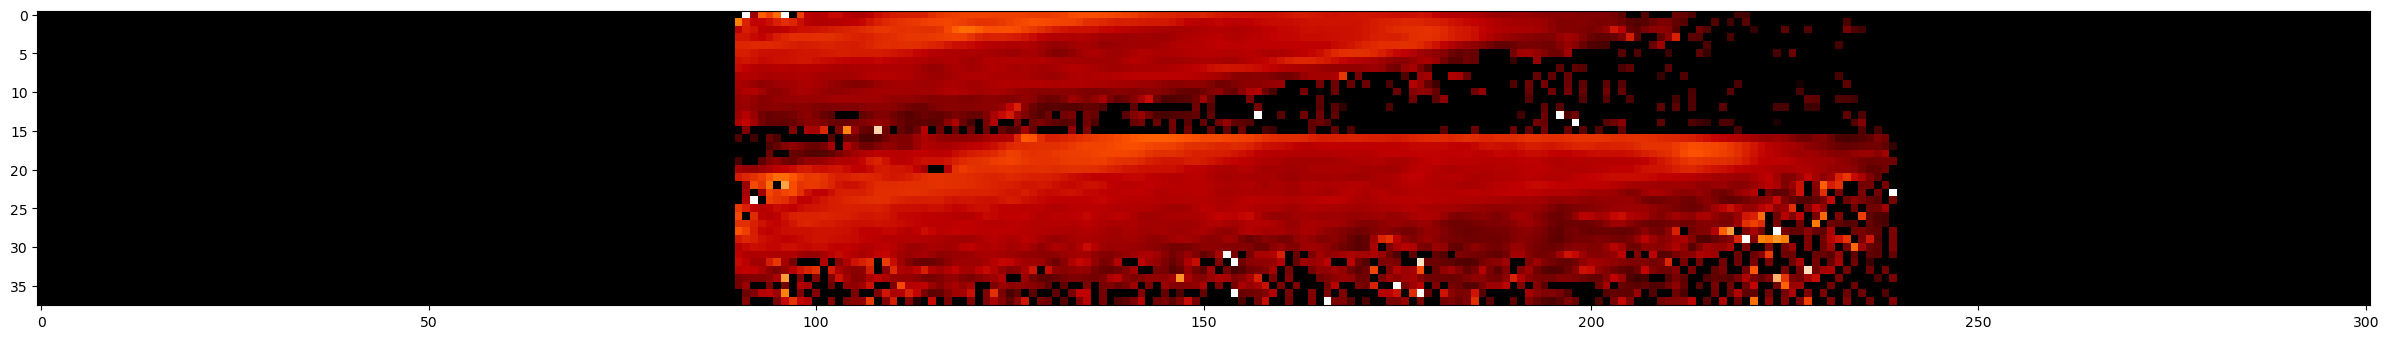

In [22]:
h3p_dens_map[h3p_dens_map > 5e17] = np.nan

fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(h3p_dens_map, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
# plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - Intensity', loc='left', fontsize=18)
# plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

i = 125, density = 1.0612766554611302e+16, temp = 893.8324126605402


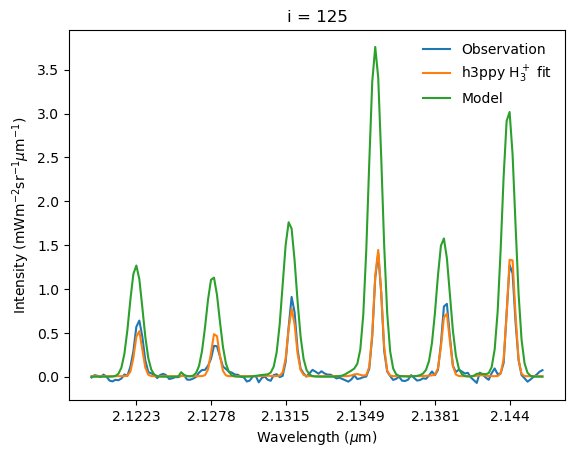

In [11]:
import h3ppy
import logging
logging.disable(logging.CRITICAL)

h3p = h3ppy.h3p(line_list_file='h3p_line_list_neale_1996_subset_211_215.txt')
h2 = h3ppy.h2()

model = h3p.model(density = 2e16, temperature = 1000, R = 25000, wavelength = wave36_to_fit)
# model2 = h2.model(density = 3e25, temperature = 1000, R = 25000, wavelength = wave)

centers = [2.1223, 2.1278, 2.1315, 2.1349, 2.1381, 2.144] # 2.1349
cpos = np.arange(6) * 25 + 15

density = np.zeros(301)
density_errs = np.zeros(301)

temp = np.zeros(301)
temp_errs = np.zeros(301)

offset_0 = np.zeros(301)
sigma_0 = np.zeros(301)
background_0 = np.zeros(301)

tot_em = np.zeros(301)

fn = 16

for i in range(125,126):
    spec = spec36_dat[fn][i]

    h3p.set(wavelength = wave36_to_fit, data = spec, R = 25000, density = 3e16, temperature = 1000)

    xx = range(len(spec))

    fit = h3p.fit(params_to_fit=['density','temperature', 'offset_0', 'sigma_0', 'background_0'], verbose=False)

    vars, errs = h3p.get_results(verbose=False)

    if bool(vars)== False:
        print('i = '+str(i)+', false fit')

#         fig, ax = plt.subplots()
#         ax.plot(xx, spec * 1e3, '-', label = 'Observation')
#         ax.plot(xx, fit * 1e3, label = 'h3ppy H$_3^+$ fit')
#         ax.plot(xx, model * 1e3, label = 'Model')
#         ax.set(xlabel = h3p.xlabel(), ylabel = h3p.ylabel(prefix = 'm'), xticks = cpos, title = 'i = '+str(i))
#         ax.set_xticklabels(centers)
#         ax.legend(frameon = False)

        continue
    if bool(vars) == True:
        print('i = '+str(i)+', density = '+str(vars['density'])+', temp = '+str(vars['temperature']))

        fig, ax = plt.subplots()
        ax.plot(xx, spec * 1e3, '-', label = 'Observation')
        ax.plot(xx, fit * 1e3, label = 'h3ppy H$_3^+$ fit')
        ax.plot(xx, model * 1e3, label = 'Model')
        ax.set(xlabel = h3p.xlabel(), ylabel = h3p.ylabel(prefix = 'm'), xticks = cpos, title = 'i = '+str(i))
        ax.set_xticklabels(centers)
        ax.legend(frameon = False)

        density[i] = vars['density']
        density_errs[i] = errs['density']

        temp[i] = vars['temperature']
        temp_errs[i] = errs['temperature']

        tot_em[i] = h3p.total_emission()

In [1]:
h3p_int2 = np.flip(h3p_int, axis=1)
temp[temp<0] = np.nan
density[density<0] = np.nan
# h3p_int2 = np.roll(h3p_int_flipped[16:27], 14, axis=1)

dmax = density + density_errs
dmin = density - density_errs

tmax = temp + temp_errs
tmin = temp - temp_errs

eff_rg = range(90,230)

fig, ax = plt.subplots(figsize = (8, 5))
ax2 = ax.twinx()

ax.plot(density[eff_rg], color='b', label='Density')
ax.plot(dmax[eff_rg], color='b', alpha=0.1)
ax.plot(dmin[eff_rg], color='b', alpha=0.1)
ax.fill_between(range(len(dmax[eff_rg])), dmin[eff_rg], dmax[eff_rg], color='b', alpha=0.1)

# ax.plot(tot_em[eff_rg], color='gold')

ax2.plot(temp[eff_rg], color='r', label='Temperature')
ax2.plot(tmax[eff_rg], color='r', alpha=0.1)
ax2.plot(tmin[eff_rg], color='r', alpha=0.1)
ax2.fill_between(range(len(tmax[eff_rg])), tmin[eff_rg], tmax[eff_rg], color='r', alpha=0.1)

int2 = (h3p_int2/np.nanmax(h3p_int2[16])*np.nanmax(density))
# ax2.plot(int2[16][eff_rg], color='gold', label='Ref Sunlight')
ax.plot(int2[16][eff_rg], color='k', ls=':', label='H$_3^{+}$', lw=2.5)

ax.set_xlabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
ax.set_ylabel('Density (m$^{-2}$)', fontsize=14)
ax2.set_ylabel('Temperature (K)', fontsize=14)

ax.set_ylim(0)
ax2.set_ylim(700,1200)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=1)

NameError: name 'np' is not defined

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 30
    # variables        = 6
    chi-square         = 4.9733e-08
    reduced chi-square = 2.0722e-09
    Akaike info crit   = -594.533856
    Bayesian info crit = -586.126672
[[Variables]]
    a0:  0.00143072 +/- 4.0755e-05 (2.85%) (init = 0.01)
    a1:  14.9116263 +/- 0.03646932 (0.24%) (init = 15)
    a2:  1.38974620 +/- 0.03250185 (2.34%) (init = 1)
    a3:  0.00162110 +/- 2.4203e-05 (1.49%) (init = 0.001)
    a4:  1.3511e-07 +/- 4.4166e-06 (3268.96%) (init = 0)
    a5:  5.5256e-08 +/- 1.4813e-07 (268.08%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.976
    C(a3, a4) = -0.831
    C(a3, a5) =  0.724
    C(a2, a5) =  0.361
    C(a0, a2) = -0.360
    C(a2, a4) = -0.355
    C(a0, a5) =  0.250
    C(a0, a4) = -0.246
    C(a2, a3) =  0.168
    C(a0, a3) =  0.124
14.911626320650702


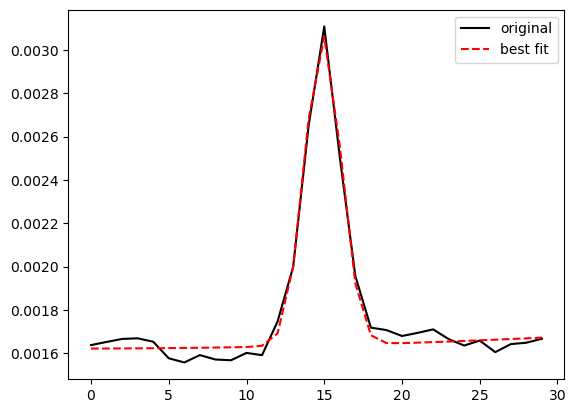

In [93]:
yy = order36_s1[150]
xx = np.linspace(0,len(yy)-1,len(yy))


# create lmfit model with defined gaussian
s_model = Model(rhp.gaussian_fit)

# create parameters and add initial guess
s_params = s_model.make_params()
s_params.add('a0', value=0.01)
s_params.add('a1', value=15)
s_params.add('a2', value=1)
s_params.add('a3', value=0.001)
s_params.add('a4', value=0)
s_params.add('a5', value=0)

try:
    s_result = s_model.fit(yy, s_params, x=xx)
except:
    pass

print(s_result.fit_report())

plt.figure()
plt.plot(xx, yy, 'k', label='original')
plt.plot(xx, s_result.best_fit, 'r--', label='best fit')
plt.legend()

print(s_result.params['a1'].value)

In [78]:
h3p_dens_map = np.array(h3p_dens_map)
h3p_temp_map = np.array(h3p_temp_map)

h3p_dens_map_errs = np.array(h3p_dens_map_errs)
h3p_temp_map_errs = np.array(h3p_temp_map_errs)

hdu1 = fits.PrimaryHDU(h3p_dens_map)
hdu1.writeto('h3p_dens_map.fits', overwrite=True)

hdu2 = fits.PrimaryHDU(h3p_temp_map)
hdu2.writeto('h3p_temp_map.fits', overwrite=True)

hdu3 = fits.PrimaryHDU(h3p_dens_map_errs)
hdu3.writeto('h3p_dens_map_errs.fits', overwrite=True)

hdu4 = fits.PrimaryHDU(h3p_temp_map_errs)
hdu4.writeto('h3p_temp_map_errs.fits', overwrite=True)

In [27]:
spec36_set = []

# fn = 16

top = 0
bot = 250

for fn in range(len(fjc36_rs)):
    
    # order 35
    spec35_h3p = fjc35_rs[fn][top:bot,:1001]
    wave35_h3p = waverange35[:1001]
    
    spec35 = spec35_h3p

    order35_s1_off = 12.290742537910269 - 7.155130529216581
    order35_s2_off = 11.715182831885945 - 7.09831071322741
    order35_s3_off = 11.28956063826212 - 5.60760044988149

    order35_s1a = 153
    order35_s1b = 173
    order35_s2a = 500
    order35_s2b = 520
    order35_s3a = 780
    order35_s3b = 800

    order35_s1 = scipy.ndimage.shift(spec35[:,order35_s1a:order35_s1b], -order35_s1_off, order=3, mode='nearest')
    order35_s2 = scipy.ndimage.shift(spec35[:,order35_s2a:order35_s2b], -order35_s2_off, order=3, mode='nearest')
    order35_s3 = scipy.ndimage.shift(spec35[:,order35_s3a:order35_s3b], -order35_s3_off, order=3, mode='nearest')

    spec35_to_fit = np.concatenate((order35_s1, order35_s2, order35_s3,), axis=1)
    wave35_to_fit = np.concatenate((waverange35[order35_s1a:order35_s1b], 
                                    waverange35[order35_s2a:order35_s2b], 
                                    waverange35[order35_s3a:order35_s3b],))
    
    # order 36
    spec36_h3p = np.concatenate((fjc36_rs[fn][top:bot,:89],
                                 fjc36_rs[fn][top:bot,189:201], 
                                 fjc36_rs[fn][top:bot,101:1001]), axis=1)
    wave36_h3p = np.concatenate((waverange36[:89], waverange36[189:201], waverange36[101:1001]))
    
    spec36 = spec36_h3p
    
    order36_s1_off = 4.8838425430389965
    order36_s2_off = 4.116042668652459
    order36_s3_off = 3.355469840507057
    order36_s4_off = 21.519491602566646
    order36_s5_off = 2.3968771801033846
    order36_s6_off = 1.843007030131016

    order36_s1a = 90
    order36_s1b = 120
#     wave36_s1a = 85
#     wave36_s1b = 115

    order36_s2a = 282
    order36_s2b = 304
#     wave36_s2a = 278
#     wave36_s2b = 300

    order36_s3a = 405
    order36_s3b = 435
#     wave36_s3a = 402
#     wave36_s3b = 432

    order36_s4a = 506
    order36_s4b = 531
#     wave36_s4a = 490
#     wave36_s4b = 515

    order36_s5a = 638
    order36_s5b = 660
#     wave36_s5a = 632
#     wave36_s5b = 654

    order36_s6a = 842
    order36_s6b = 865
#     wave36_s6a = 841
#     wave36_s6b = 864

    order36_s1 = spec36[:,order36_s1a:order36_s1b]
    order36_s2 = spec36[:,order36_s2a:order36_s2b]
    order36_s3 = spec36[:,order36_s3a:order36_s3b]
    order36_s4 = spec36[:,order36_s4a:order36_s4b]
    order36_s5 = spec36[:,order36_s5a:order36_s5b]
    order36_s6 = spec36[:,order36_s6a:order36_s6b]

    wave36_s1 = waverange36[order36_s1a:order36_s1b] - (order36_s1_off * 2.9080e-05)
    wave36_s2 = waverange36[order36_s2a:order36_s2b] - (order36_s2_off * 2.9080e-05)
    wave36_s3 = waverange36[order36_s3a:order36_s3b] - (order36_s3_off * 2.9080e-05)
    wave36_s4 = waverange36[order36_s4a:order36_s4b] - (order36_s4_off * 2.9080e-05)
    wave36_s5 = waverange36[order36_s5a:order36_s5b] - (order36_s5_off * 2.9080e-05)
    wave36_s6 = waverange36[order36_s6a:order36_s6b] - (order36_s6_off * 2.9080e-05)

    wave36_to_fit = np.concatenate((wave36_s1,
                                    wave36_s2,
                                    wave36_s3,
                                    wave36_s4,
                                    wave36_s5,
                                    wave36_s6,))

#     wave36_model = np.concatenate((waverange36[order36_s1a:order36_s1b], 
#                                    waverange36[order36_s2a:order36_s2b], 
#                                    waverange36[order36_s3a:order36_s3b], 
#                                    waverange36[order36_s4a:order36_s4b], 
#                                    waverange36[order36_s5a:order36_s5b], 
#                                    waverange36[order36_s6a:order36_s6b],))
    
    noise_s1 = np.mean(np.hstack((order36_s1[:,0:5],order36_s1[:,25:30])), axis=1)
    reduced_s1 = (order36_s1.transpose() - noise_s1).transpose()

    noise_s2 = np.mean(np.hstack((order36_s2[:,0:4],order36_s2[:,18:22])), axis=1)
    reduced_s2 = (order36_s2.transpose() - noise_s2).transpose()

    noise_s3 = np.mean(np.hstack((order36_s3[:,0:5],order36_s3[:,25:30])), axis=1)
    reduced_s3 = (order36_s3.transpose() - noise_s3).transpose()

    noise_s4 = np.mean(np.hstack((order36_s4[:,0:2],order36_s4[:,17:20])), axis=1)
    reduced_s4 = (order36_s4.transpose() - noise_s4).transpose()

    noise_s5 = np.mean(np.hstack((order36_s5[:,0:5],order36_s5[:,17:22])), axis=1)
    reduced_s5 = (order36_s5.transpose() - noise_s5).transpose()

    noise_s6 = np.mean(np.hstack((order36_s6[:,0:5],order36_s6[:,18:22])), axis=1)
    reduced_s6 = (order36_s6.transpose() - noise_s6).transpose()


    spec36_to_fit = np.concatenate((reduced_s1, 
                                    reduced_s2, 
                                    reduced_s3, 
                                    reduced_s4, 
                                    reduced_s5, 
                                    reduced_s6,), axis=1)
    
#     spec36_to_fit = np.concatenate((order36_s1,
#                                     order36_s2,
#                                     order36_s3,
#                                     order36_s4,
#                                     order36_s5,
#                                     order36_s6,), axis=1)
    
    # order 37
    spec37_h3p = fjc37_rs[fn][top:bot,:1001]
    wave37_h3p = waverange37[:1001]

    spec37 = spec37_h3p
    
    order37_s1_off = 10.726523847017612 - 8.272614883168751
    order37_s2_off = 8.570777141472702 - 6.927853944164028

    order37_s1a = 415
    order37_s1b = 435
    order37_s2a = 481
    order37_s2b = 496

    order37_s1 = scipy.ndimage.shift(spec37[:,order37_s1a:order37_s1b], -order37_s1_off, order=3, mode='nearest')
    order37_s2 = scipy.ndimage.shift(spec37[:,order37_s2a:order37_s2b], -order37_s2_off, order=3, mode='nearest')


    spec37_to_fit = np.concatenate((order37_s1, order37_s2,), axis=1)
    wave37_to_fit = np.concatenate((waverange37[order37_s1a:order37_s1b],
                                    waverange37[order37_s2a:order37_s2b],))


    spec_to_fit = np.concatenate((spec37_to_fit, spec36_to_fit, spec35_to_fit,), axis=1)
    wave_to_fit = np.concatenate((wave37_to_fit, wave36_to_fit, wave35_to_fit))

    spec36_set.append(spec36_to_fit)
    
spec36_dat = np.array(spec36_set)